In [ ]:
# Run on google collab
!pip install transformers
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 46.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 51.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 17.7 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.7/468.7 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 kB 27.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 25.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 kB 17.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 269.3/269.3 kB 26.8 MB/s eta 0:00:0

In [3]:
import torch
import transformers
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader
from datasets import load_dataset
import matplotlib.pyplot as plt

# Data loading

In [ ]:
# Load SILICONE dataset in its Dyda_da config
silicone_dyda = load_dataset('silicone', 'dyda_da')
dyda_train = silicone_dyda['train']
dyda_valid = silicone_dyda['validation']
dyda_test = silicone_dyda['test']

Generating train split:   0%|          | 0/87170 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/8069 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7740 [00:00<?, ? examples/s]

Dataset silicone downloaded and prepared to /root/.cache/huggingface/datasets/silicone/dyda_da/1.0.0/af617406c94e3f78da85f7ea74ebfbd3f297a9665cb54adbae305b03bc4442a5. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
print(dyda_train)
dyda_train_df = pd.DataFrame.from_dict(dyda_train[:])
dyda_train_df.head()

Dataset({
    features: ['Utterance', 'Dialogue_Act', 'Dialogue_ID', 'Label', 'Idx'],
    num_rows: 87170
})


,Utterance,Dialogue_Act,Dialogue_ID,Label,Idx
0,"say , jim , how about going for a few beers af...",directive,1,1,0
1,you know that is tempting but is really not go...,commissive,1,0,1
2,what do you mean ? it will help us to relax .,question,1,3,2
3,do you really think so ? i don't . it will jus...,question,1,3,3
4,i guess you are right.but what shall we do ? i...,question,1,3,4


<class 'pandas.core.series.Series'>
inform        39873
question      24974
directive     14242
commissive     8081
Name: Dialogue_Act, dtype: int64


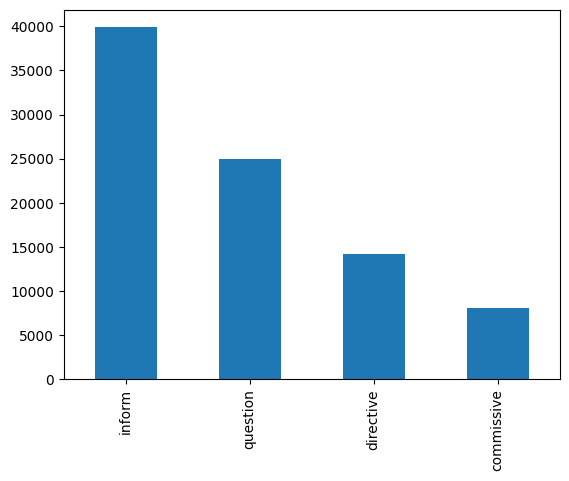

In [ ]:
# Plot DA distribution in Dyda_da
counts = dyda_train_df['Dialogue_Act'].value_counts()
print(type(counts))
print(counts)
counts.plot.bar()
plt.savefig('DA_distribution.png')
plt.show()

# Preprocessing and BERT model

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

model_name = "bert-base-uncased" 

# Tokenizer and BERT
tokenizer = transformers.BertTokenizer.from_pretrained(model_name)
model = transformers.BertForSequenceClassification.from_pretrained(model_name, num_labels=4)
model.to(device)

cuda


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [ ]:
# Tokenization test
text= "Hello my friend"
tokens = tokenizer.encode_plus(text, max_length= 128, padding='max_length', truncation=True, return_tensors='pt')
input_ids = tokens['input_ids']
input_ids = input_ids.to(device)
attention_mask = tokens['attention_mask']
attention_mask = attention_mask.to(device)
output = model(input_ids, attention_mask)
print(output)

SequenceClassifierOutput(loss=None, logits=tensor([[ 0.4524,  0.4811, -0.1474,  0.5400]], device='cuda:0',
       grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)


In [ ]:
#Training parameters
batch_size = 16
learning_rate = 2e-5
num_epochs = 3

max_seq_length = 128

# Preprocessing
train_data = dyda_train.map(lambda x: {"input_ids": (tokenizer.encode_plus(x["Utterance"], max_length=128, padding='max_length', truncation=True, return_tensors='pt'))['input_ids'], "attention_mask": (tokenizer.encode_plus(x["Utterance"], max_length=max_seq_length, padding='max_length', truncation=True, return_tensors='pt'))['attention_mask'], "label": x["Label"]})
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

val_data = dyda_valid.map(lambda x: {"input_ids": (tokenizer.encode_plus(x["Utterance"], max_length=128, padding='max_length', truncation=True, return_tensors='pt'))['input_ids'], "attention_mask": (tokenizer.encode_plus(x["Utterance"], max_length=max_seq_length, padding='max_length', truncation=True, return_tensors='pt'))['attention_mask'], "label": x["Label"]})
val_dataloader = DataLoader(val_data, batch_size=batch_size, shuffle=True)

test_data = dyda_test.map(lambda x: {"input_ids": (tokenizer.encode_plus(x["Utterance"], max_length=128, padding='max_length', truncation=True, return_tensors='pt'))['input_ids'], "attention_mask": (tokenizer.encode_plus(x["Utterance"], max_length=max_seq_length, padding='max_length', truncation=True, return_tensors='pt'))['attention_mask'], "label": x["Label"]})
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

Map:   0%|          | 0/87170 [00:00<?, ? examples/s]

Map:   0%|          | 0/8069 [00:00<?, ? examples/s]

Map:   0%|          | 0/7740 [00:00<?, ? examples/s]

# Model training and results

In [ ]:
#Optimizer et loss function
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
loss_fn = torch.nn.CrossEntropyLoss()

# Training and Validation
for epoch in range(num_epochs):
    print(f"Start Epoch {epoch + 1}/{num_epochs}")
    total_loss = 0.0
    total_count = 0
    for batch in train_dataloader: 
        # Extraire les entrées et les labels de la batch
        input_ids = torch.stack(batch["input_ids"][0], dim=0)
        input_ids=torch.transpose(input_ids, 0, 1)
        input_ids = input_ids.to(device)
        attention_mask = torch.stack(batch["attention_mask"][0], dim=0)
        attention_mask=torch.transpose(attention_mask, 0, 1)
        attention_mask = attention_mask.to(device)
        labels = batch["label"]
        labels = labels.to(device)

        # Calculer la loss et les gradients
        optimizer.zero_grad()
        outputs = model(input_ids,attention_mask)
        loss = loss_fn(outputs.logits, labels)
        total_loss += loss.item() * len(batch["label"])
        total_count += len(batch["label"])
        loss.backward()
        optimizer.step()

    avg_loss = total_loss / total_count
    print(f"Epoch {epoch + 1}: train_loss={avg_loss:.4f}")

    # Evaluate model on validation set after each epoch
    with torch.no_grad():
        total_loss = 0.0
        total_correct = 0
        total_count = 0
        # No need to batch here but I keep the same structure and I have encountered errors doing otherwise
        for batch in val_dataloader:
            input_ids = torch.stack(batch["input_ids"][0], dim=0)
            input_ids=torch.transpose(input_ids, 0, 1)
            input_ids = input_ids.to(device)
            attention_mask = torch.stack(batch["attention_mask"][0], dim=0)
            attention_mask=torch.transpose(attention_mask, 0, 1)
            attention_mask = attention_mask.to(device)
            labels = batch["label"]
            labels = labels.to(device)
            
            outputs = model(input_ids,attention_mask)
            loss = loss_fn(outputs.logits, labels)

            total_loss += loss.item() * len(batch["label"])
            total_correct += (outputs.logits.argmax(dim=1) == labels).sum().item()
            total_count += len(batch["label"])

        avg_loss = total_loss / total_count
        accuracy = total_correct / total_count
        print(f"Epoch {epoch + 1}: val_loss={avg_loss:.4f}, val_acc={accuracy:.4f}")


# Test
with torch.no_grad():
  total_correct = 0
  total_count = 0
  # No need to batch here but I keep the same structure and I have encountered errors doing otherwise
  for batch in test_dataloader:
    input_ids = torch.stack(batch["input_ids"][0], dim=0)
    input_ids=torch.transpose(input_ids, 0, 1)
    input_ids = input_ids.to(device)
    attention_mask = torch.stack(batch["attention_mask"][0], dim=0)
    attention_mask=torch.transpose(attention_mask, 0, 1)
    attention_mask = attention_mask.to(device)
    labels = batch["label"]
    labels = labels.to(device)
            
    outputs = model(input_ids,attention_mask)

    total_correct += (outputs.logits.argmax(dim=1) == labels).sum().item()
    total_count += len(batch["label"])

  accuracy = total_correct / total_count
  print(f"test_acc={accuracy:.4f}")

Start Epoch 1/3
Epoch 1: train_loss=0.4910
Epoch 1: val_loss=0.5150, val_acc=0.7977
Start Epoch 2/3
Epoch 2: train_loss=0.3736
Epoch 2: val_loss=0.5331, val_acc=0.7989
Start Epoch 3/3


In [ ]:
# Test
with torch.no_grad():
  total_correct = 0
  total_count = 0
  # No need to batch here but I keep the same structure and I have encountered errors doing otherwise
  for batch in test_dataloader:
    input_ids = torch.stack(batch["input_ids"][0], dim=0)
    input_ids=torch.transpose(input_ids, 0, 1)
    input_ids = input_ids.to(device)
    attention_mask = torch.stack(batch["attention_mask"][0], dim=0)
    attention_mask=torch.transpose(attention_mask, 0, 1)
    attention_mask = attention_mask.to(device)
    labels = batch["label"]
    labels = labels.to(device)
            
    outputs = model(input_ids,attention_mask)

    total_correct += (outputs.logits.argmax(dim=1) == labels).sum().item()
    total_count += len(batch["label"])

  accuracy = total_correct / total_count
  print(f"test_acc={accuracy:.4f}")

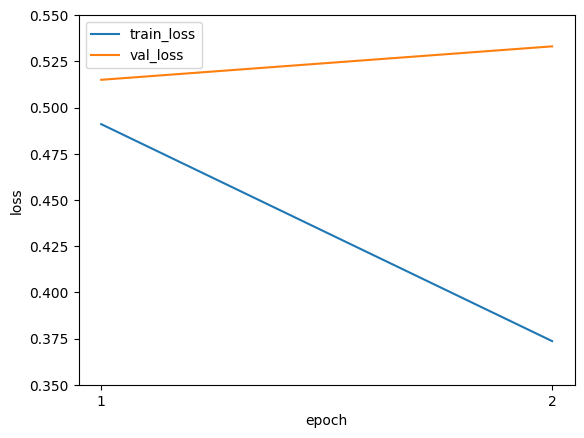

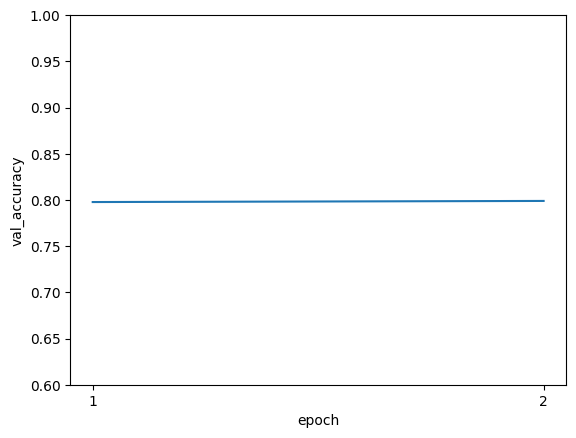

In [16]:
#plot results
epoch = [1,2]
train_loss = [0.4910,0.3736]
val_loss = [0.5150, 0.5331]
val_accuracy = [0.7977, 0.7989]

plt.plot(epoch,train_loss,label='train_loss')
plt.plot(epoch,val_loss,label='val_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
ticks = np.unique(epoch)
plt.xticks(ticks)
plt.ylim(0.35, 0.55)
plt.savefig('losses')

plt.figure()
plt.plot(epoch,val_accuracy)
plt.xlabel('epoch')
plt.ylabel('val_accuracy')
ticks = np.unique(epoch)
plt.xticks(ticks)
plt.ylim(0.6, 1)
plt.savefig('val_accuracy')

plt.show()